# Analysis of PageRank Algorithm on PPI network
I created a PPI network using the interactions from ConsensusPathDB and I joined it with gene expression data (dual RNA-seq) obtained for the legionella infection setting.

In the dual RNA-seq, we have the following groups:
* *Control* (not treated)
* *GFP+* (cells with legionella infection)
* *GFP-* (cells without legionella)
* *PAM3* (inflammatory substance treatment. Should produce results similar to GFP+)

The gene expression for ~40.000 genes was preprocessing in the following way:
* Kick out genes whose average gene expression was higher than $10 \times$ the standard deviation
* Kick out genes with only less than 50% of the gene expressions being different from 0

The network was then constructed for those genes only. That is, an edge is drawn between two genes only if both of them are in the list of genes for which we have gene expression and if the confidence of the interactions exceed $0.5$.

After network construction, isolated genes (no edges for gene) got kicked out as well. I am afterwards left with a network of 10398 genes AND 161231 interactions.

On this network I applied the well-known PageRank algorithm. This resulted in a score for each gene and a higher score means that the gene is more important in the network.

**The goal of this notebook is to evaluate the results from PageRank, look into correlations with gene expression/differential expression, pathways and finally visualize the important genes in the network.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
%matplotlib inline

## Load NetRank scores & Indices
This loads the the scores from our NetRank algorithm as well as the raw network from our hdf5 container.

In [23]:
# load gene expression values and network
fname = '../data/preprocessing/legionella_gcn_input.h5'
with h5py.File(fname, 'r') as f:
    gene_expression_data = pd.DataFrame(f['features'][:])
    ppi_network = f['network'][:]
    gene_names = f['gene_names'][:]

# load pagerank scores and ranks
netrank_scores = pd.DataFrame.from_csv('../data/pagerank/netrank_scores.txt',
                                       encoding='utf-8',
                                       sep='\t',
                                       index_col=0
                                      )

In [24]:
print (netrank_scores.shape, ppi_network.shape)

(9991, 3) (9991, 9991)


## Correlations between NetRank & Gene Expression Variance
Let's check the correlations between the NetRank (Google Goes Cancer) and the variance of the gene expression. Trivially, one would expect that the high variance genes would be more prominent in the network.

However, there are a couple of factors that introduce noise here:
* The variance is calculated over 3 replicates of GFP+, GFP-, Control and PAM3. A couple of these groups are not expected to change during the time course of the infection so looking at the variance doesn't nessessarily make sense.
* There is experimental bias in here as well. Sometimes the replicates have very high variance, even though the gene is not at all differentially expressed.

In [25]:
# get the IDs from file and set them as index axis for the expression
expr_with_names = gene_expression_data.set_index(gene_names[:, 0]) #they have the same ordering

# set gene expression variance, mean and median and add to dataframe
expr_var = pd.DataFrame(expr_with_names.var(axis=1))
expr_var.columns = ['Gene_Expression_Variance']
expr_mean = pd.DataFrame(expr_with_names.mean(axis=1))
expr_mean.columns = ['Gene_Expression_Mean']
expr_median = pd.DataFrame(expr_with_names.median(axis=1))
expr_median.columns = ['Gene_Expression_Median']
netrank_with_ge = netrank_scores.join([expr_var, expr_mean, expr_median])

# write that to file
netrank_with_ge.to_csv('../pagerank/netrank_scores_with_ge.txt', sep='\t')
netrank_with_ge.head()

,Gene_Name,Rank,NetRank_Score,Gene_Expression_Variance,Gene_Expression_Mean,Gene_Expression_Median
Gene_ID,,,,,,
ENSG00000173110,HSPA6,1,0.074021,2.615623e+09,26667.060916,1362.645944
ENSG00000109846,CRYAB,2,0.022357,8.156371e+04,134.951849,5.256797
ENSG00000166592,RRAD,3,0.006015,3.901495e+04,128.220834,37.369897
ENSG00000198400,NTRK1,4,0.003792,1.842957e+01,5.889578,4.758743
ENSG00000141510,TP53,5,0.003583,4.185298e+01,14.192954,13.986278


In [26]:
# compute correlation between gene expression and pagerank
#sorted_gene_expression = pagerank_with_ge.sort_values(by='Gene_Expression_Median', ascending=False)
print ("Correlation between NetRank & GE Mean: {}". \
       format(netrank_with_ge.Gene_Expression_Mean.corr(netrank_with_ge.NetRank_Score)))
print ("Correlation between NetRank & GE Variance: {}". \
       format(netrank_with_ge.Gene_Expression_Variance.corr(netrank_with_ge.NetRank_Score)))
print ("Correlation between NetRank & GE Median: {}". \
       format(netrank_with_ge.Gene_Expression_Median.corr(netrank_with_ge.NetRank_Score)))

Correlation between NetRank & GE Mean: 0.28704444739887025
Correlation between NetRank & GE Variance: 0.2500795118784458
Correlation between NetRank & GE Median: 0.06413995670107399


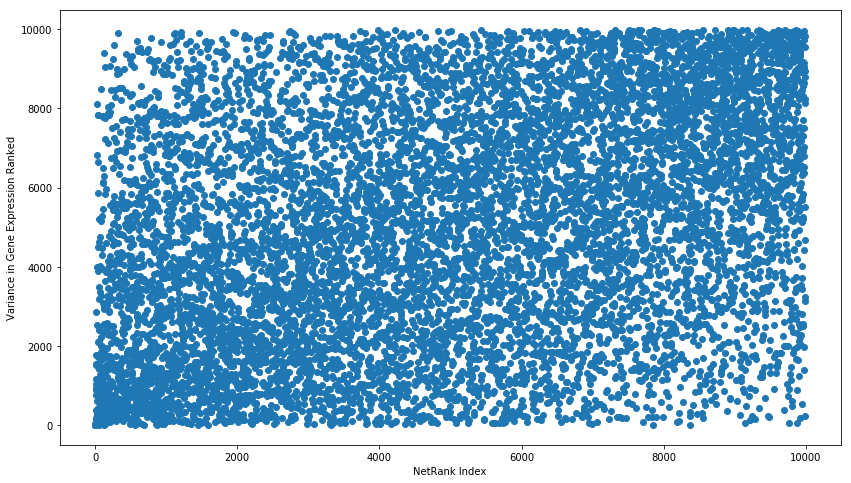

In [27]:
fig = plt.figure(figsize=(14, 8))
ranked_ge_var = np.argsort(netrank_with_ge.Gene_Expression_Variance)[::-1]
ax = plt.scatter(netrank_with_ge.Rank, ranked_ge_var)
#plt.xlim([0, 0.004])
t = plt.xlabel('NetRank Index')
t = plt.ylabel('Variance in Gene Expression Ranked')

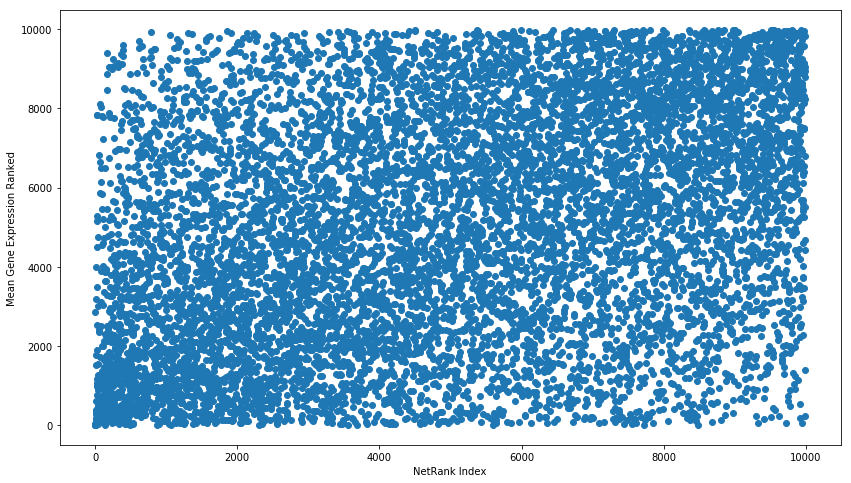

In [28]:
fig = plt.figure(figsize=(14, 8))
ranked_ge_mean = np.argsort(netrank_with_ge.Gene_Expression_Mean)[::-1]
ax = plt.scatter(netrank_with_ge.Rank, ranked_ge_mean)
#plt.xlim([0, 0.004])
t = plt.xlabel('NetRank Index')
t = plt.ylabel('Mean Gene Expression Ranked')

## Correlations between PageRank & Differential Expression
Because of the flaws of using only the variance, let's try having a look at the differentially expressed genes.
This should overcome the issues and maybe reveal some correlation between PageRank and DE.

Unfortunately, we only have GE data for the differentially expressed genes, while for all others, the p-values are $<0.05$

In [29]:
# load DE for GFP+ vs. Control for up and down-regulated genes (unfortunately, we only have pvalue < .05)
differential_expression_up = pd.read_html('../data/differential_expression/DEanalysis/gpp1605-up.html',
                                       index_col=2,
                                       header=0
                                      )[0]
differential_expression_down = pd.read_html('../data/differential_expression/DEanalysis/gpp1605-down.html',
                                           index_col=2,
                                           header=0
                                           )[0]

# concatenate the up and down-regulated genes
differential_expression_down.drop('Ensembl', inplace=True)
differential_expression_down = differential_expression_down.convert_objects(convert_numeric=True)
differential_expression = pd.concat([differential_expression_up, differential_expression_down])

# remove gene name (already there)
differential_expression.drop('Gene-name', axis=1, inplace=True)
differential_expression.shape

/pkg/python-3.6.0-0/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


(8877, 7)

In [30]:
netrank_ge_and_de = netrank_with_ge.join(differential_expression)

# compute correlation between differential expression and netrank
print ("Correlation between NetRank & DE pvalue: {}". \
       format(netrank_ge_and_de.pvalue.corr(netrank_ge_and_de.NetRank_Score)))
print ("Correlation between NetRank & DE log2FoldChange: {}". \
       format(netrank_ge_and_de.log2FoldChange.corr(netrank_ge_and_de.NetRank_Score)))
print ("Correlation between NetRank & GE baseMean: {}". \
       format(netrank_ge_and_de.baseMean.corr(netrank_ge_and_de.NetRank_Score)))

Correlation between NetRank & DE pvalue: -0.03785707688819477
Correlation between NetRank & DE log2FoldChange: 0.11494858720129503
Correlation between NetRank & GE baseMean: 0.2993612342824557


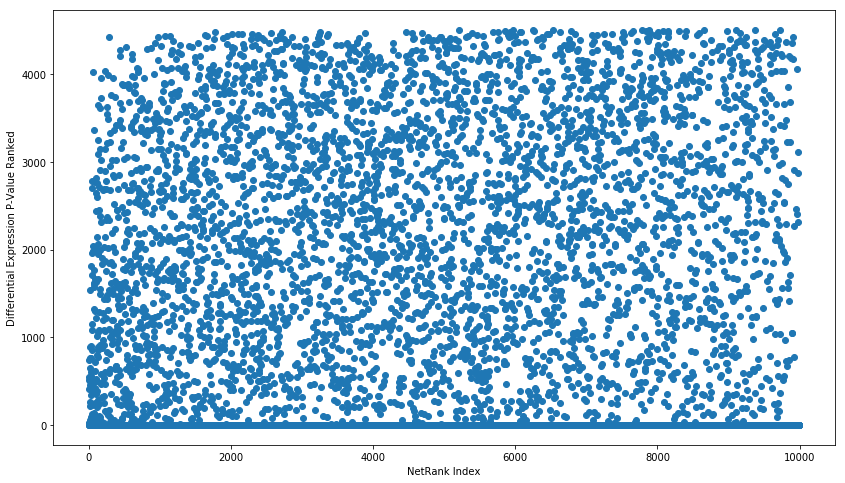

In [31]:
fig = plt.figure(figsize=(14, 8))
ranked_de = np.argsort(netrank_ge_and_de.pvalue)
ax = plt.scatter(netrank_ge_and_de.Rank, ranked_de)
#plt.xlim([0, 0.004])
t = plt.xlabel('NetRank Index')
t = plt.ylabel('Differential Expression P-Value Ranked')

## Correlations between PageRank & Gene Expression PCA Loadings
When the variance/mean of the gene expression doesn't correlate with the PageRank, let's try something different.
I want to see if there is a correlation between the PCA loadings from the 20% most varying  genes and the PageRank.

In [32]:
loadings_pc1 = pd.DataFrame.from_csv('../data/preprocessing/loadings_comp_1.tsv',
                                     sep='\t'
                                    )
loadings_pc1 = loadings_pc1.drop(['Abs_Loadings', 'Gene_Name'], axis=1)

loadings_pc2 = pd.DataFrame.from_csv('../data/preprocessing/loadings_comp_2.tsv',
                                     sep='\t'
                                    )
loadings_pc2 = loadings_pc2.drop(['Abs_Loadings', 'Gene_Name'], axis=1)

loadings_pc3 = pd.DataFrame.from_csv('../data/preprocessing/loadings_comp_3.tsv',
                                     sep='\t'
                                    )
loadings_pc3 = loadings_pc3.drop(['Abs_Loadings', 'Gene_Name'], axis=1)

In [33]:
netrank_de_ge_loadings = netrank_ge_and_de
for comp in range(1, 4):
    loadings = pd.DataFrame.from_csv('../data/preprocessing/loadings_comp_{}.tsv'.format(comp),
                                         sep='\t'
                                        )
    loadings.drop('Abs_Loadings', axis=1, inplace=True)
    loadings.drop('Gene_Name', axis=1, inplace=True) # gene name is already there
    loadings.columns = ['Loadings_Comp{}'.format(comp)]
    netrank_de_ge_loadings = netrank_de_ge_loadings.join(loadings, how='left')
    print (netrank_de_ge_loadings.shape)
netrank_de_ge_loadings.head()

(9991, 14)
(9991, 15)
(9991, 16)


,Gene_Name,Rank,NetRank_Score,Gene_Expression_Variance,Gene_Expression_Mean,Gene_Expression_Median,Gene-type,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Loadings_Comp1,Loadings_Comp2,Loadings_Comp3
Gene_ID,,,,,,,,,,,,,,,,
ENSG00000173110,HSPA6,1,0.074021,2.615623e+09,26667.060916,1362.645944,protein_coding,26667.060916,6.131800,0.678802,9.033272,NaN,NaN,0.305568,0.105032,-0.014434
ENSG00000109846,CRYAB,2,0.022357,8.156371e+04,134.951849,5.256797,protein_coding,134.951849,8.181148,0.561477,14.570755,4.311022e-48,1.065771e-44,0.001990,0.001336,-0.000145
ENSG00000166592,RRAD,3,0.006015,3.901495e+04,128.220834,37.369897,protein_coding,128.220834,6.382901,0.556047,11.479067,1.680848e-30,1.154276e-27,0.001291,0.001302,-0.000544
ENSG00000198400,NTRK1,4,0.003792,1.842957e+01,5.889578,4.758743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000141510,TP53,5,0.003583,4.185298e+01,14.192954,13.986278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


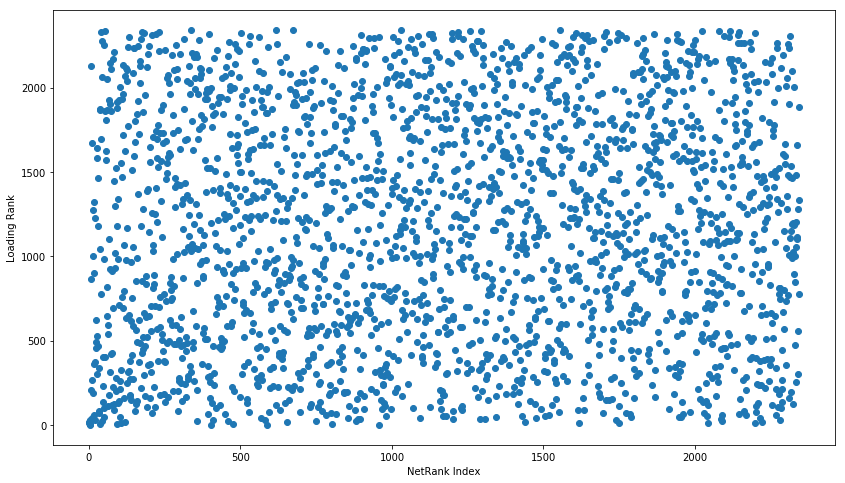

In [34]:
fig = plt.figure(figsize=(14, 8))
pc1_df = loadings_pc1.join(netrank_ge_and_de)
pc1_df.dropna(axis=0, inplace=True)
ranked_loadings_pc1 = np.argsort(pc1_df.Loadings)[::-1]
plt.scatter(np.argsort(pc1_df.Rank), ranked_loadings_pc1)
plt.xlabel('NetRank Index')
plt.ylabel('Loading Rank')

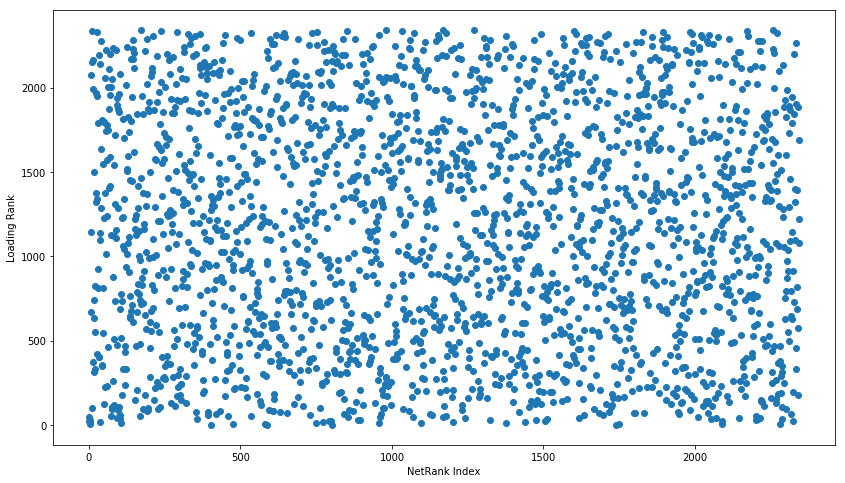

In [35]:
fig = plt.figure(figsize=(14, 8))
pc2_df = loadings_pc2.join(netrank_ge_and_de)
pc2_df.dropna(axis=0, inplace=True)
ranked_loadings_pc2 = np.argsort(pc2_df.Loadings)[::-1]
plt.scatter(np.argsort(pc2_df.Rank), ranked_loadings_pc2)
plt.xlabel('NetRank Index')
plt.ylabel('Loading Rank')

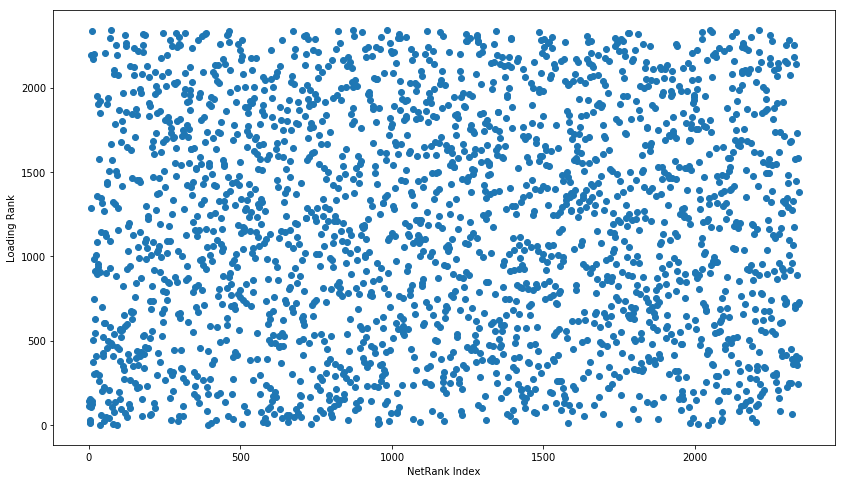

In [36]:
fig = plt.figure(figsize=(14, 8))
pc3_df = loadings_pc3.join(netrank_ge_and_de)
pc3_df.dropna(axis=0, inplace=True)
ranked_loadings_pc3 = np.argsort(pc3_df.Loadings)
plt.scatter(np.argsort(pc3_df.Rank), ranked_loadings_pc3)
plt.xlabel('NetRank Index')
plt.ylabel('Loading Rank')

## Correlations of PageRank and Network Properties
Next, I'd like to do a sanity check. The PageRank should somehow correlate with basic network properties, such as:
* Node Degree
* Betweenness
* etc.

In [40]:
import networkx as nx

In [46]:
G = nx.from_numpy_matrix(A=ppi_network)
node_degree = nx.degree(G)
degree_np = np.zeros(len(node_degree))
if float(nx.__version__) >= 2:
    for key, val in node_degree:
        degree_np[key] = val
else:
    for key, val in node_degree.items():
        degree_np[key] = val
print ("Mean Node Degree in PPI Network: {}".format(degree_np.mean()))

Mean Node Degree in PPI Network: 33.213632585203655


In [47]:
netrank_ge_and_de.Rank.shape

(9624,)

In [54]:
degree_np.shape

(9624,)

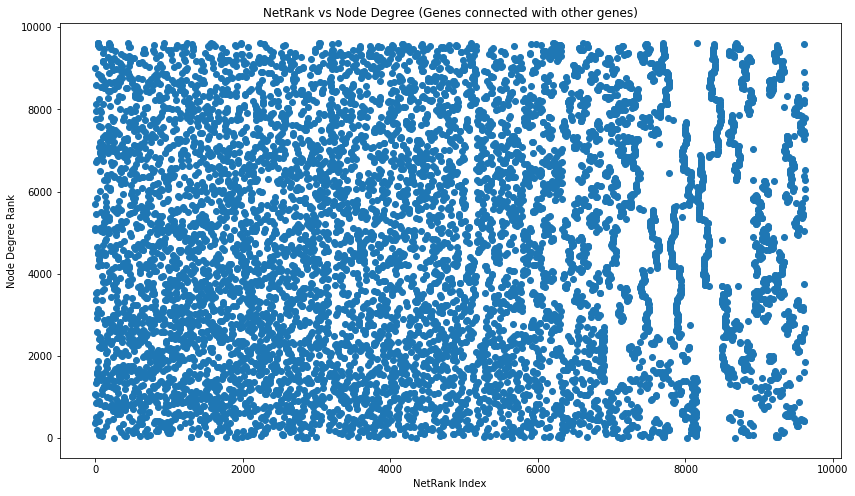

In [55]:
fig = plt.figure(figsize=(14, 8))
degree_rank = np.argsort(degree_np)[::-1]
plt.scatter(netrank_ge_and_de.Rank, degree_rank)
plt.title('NetRank vs Node Degree (Genes connected with other genes)')
plt.xlabel('NetRank Index')
plt.ylabel('Node Degree Rank')

In [56]:
# centrality now (takes time)
betweenness_centrality = nx.betweenness_centrality(G)

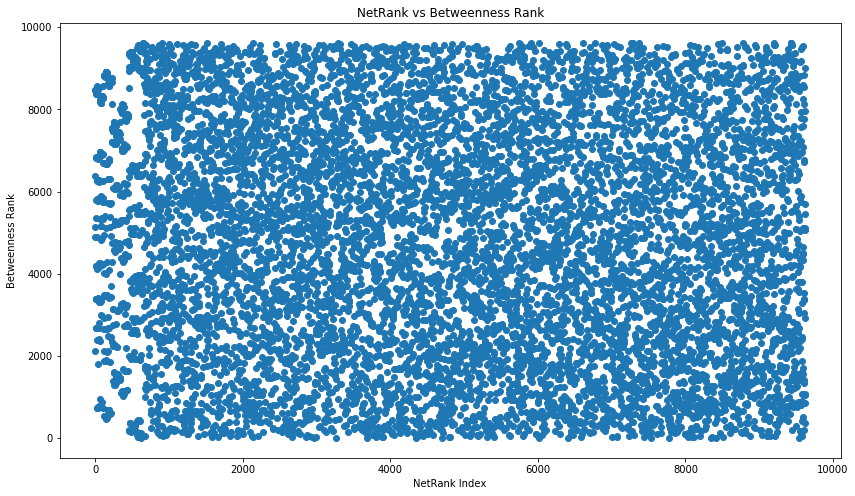

In [57]:
betweenness_np = np.zeros(len(node_degree))
for key, val in betweenness_centrality.items():
    betweenness_np[key] = val

fig = plt.figure(figsize=(14, 8))
betweenness_rank = np.argsort(betweenness_np)
plt.scatter(netrank_ge_and_de.Rank, betweenness_rank)
plt.title('NetRank vs Betweenness Rank')
plt.xlabel('NetRank Index')
plt.ylabel('Betweenness Rank')

### Fuse Dataframe with gene expression, differential expression, loadings and network properties

In [58]:
network_props = pd.DataFrame(np.vstack([degree_np, betweenness_np]).T)
network_props.columns = ['Node_Degree', 'Node_Betweenness']
network_props = network_props.set_index(gene_names[:, 0])
netrank_whole_props = netrank_de_ge_loadings.join(network_props)

In [59]:
# compute correlation between gene expression and pagerank
print ("Correlation between PageRank & Node Degree: {}". \
       format(netrank_whole_props.Node_Degree.corr(netrank_whole_props.NetRank_Score)))
print ("Correlation between PageRank & Node Betweenness: {}". \
       format(netrank_whole_props.Node_Betweenness.corr(netrank_whole_props.NetRank_Score)))

Correlation between PageRank & Node Degree: 0.0701651041234538
Correlation between PageRank & Node Betweenness: 0.07014323769486057


## Write Whole Dataframe to Disk

In [60]:
netrank_whole_props.to_csv('../data/pagerank/netrank_properties.tsv', sep='\t')
#netrank_whole_props

## Do Wigos genes pop up in my top candidates?
I found some high correlation between network properties, differential expression and gene expression with the results from PageRank.

Next, I want to know if any of the high ranked genes also pop up in the list that I got from Wigo.

In [37]:
infection_genes = pd.DataFrame.from_csv('../data/labels/labels_wigo_codingonly.csv', sep='\t', index_col=3)
my_infection_genes = pd.DataFrame.from_csv('../data/labels/labels_wigo_extended.tsv',
                                           sep='\t',
                                           index_col=1
                                          )
infection_genes = infection_genes.append(my_infection_genes)

In [38]:
infection_genes.shape

(46, 13)

In [39]:
count = 0
mean_score = 0
for index, row in infection_genes.iterrows():
    if index in netrank_scores.index:
        print ('Found Ensembl ID {} ({})\tNetRank: {}'\
               .format(index, row['Gene-name'], netrank_scores.loc[index]['Rank'])
              )
        mean_score += netrank_scores.loc[index]['Rank']
        count += 1
print ("-------------------------------------------")
print ("Total items found in Wigos List and the network: {}".format(count))
print ("Total number of infection genes (labels): {}".format(infection_genes.shape[0]))
print ("Mean Netrank Score for labels: {}".format(mean_score / count))

Found Ensembl ID ENSG00000144381 (HSPD1)	NetRank: 185
Found Ensembl ID ENSG00000149257 (SERPINH1)	NetRank: 1038
Found Ensembl ID ENSG00000086061 (DNAJA1)	NetRank: 943
Found Ensembl ID ENSG00000105993 (DNAJB6)	NetRank: 64
Found Ensembl ID ENSG00000170606 (HSPA4)	NetRank: 73
Found Ensembl ID ENSG00000087074 (PPP1R15A)	NetRank: 2091
Found Ensembl ID ENSG00000013441 (CLK1)	NetRank: 1465
Found Ensembl ID ENSG00000168439 (STIP1)	NetRank: 378
Found Ensembl ID ENSG00000114416 (FXR1)	NetRank: 1467
Found Ensembl ID ENSG00000004478 (FKBP4)	NetRank: 851
Found Ensembl ID ENSG00000184205 (TSPYL2)	NetRank: 1148
Found Ensembl ID ENSG00000092531 (SNAP23)	NetRank: 1723
Found Ensembl ID ENSG00000099860 (GADD45B)	NetRank: 3586
Found Ensembl ID ENSG00000160570 (DEDD2)	NetRank: 3026
Found Ensembl ID ENSG00000008294 (SPAG9)	NetRank: 3078
Found Ensembl ID ENSG00000108510 (MED13)	NetRank: 3167
Found Ensembl ID ENSG00000143514 (TP53BP2)	NetRank: 951
Found Ensembl ID ENSG00000135517 (Mip)	NetRank: 7997
Found Ens

## Add label column to network properties
For visualization in cytoscape, it will be helpful if the labeled genes are marked somehow. Here, I add a label column to the already calculated network properties to have a look at their distribution in the network.

In [19]:
# load dataframe and add label column
#netrank_whole_props = pd.DataFrame.from_csv('../data/pagerank/netrank_properties.tsv', sep='\t')
netrank_whole_props['is_label'] = False

# only select infection genes present in the data
infection_genes_present = infection_genes[infection_genes.index.isin(netrank_whole_props.index)]
netrank_whole_props.ix[infection_genes_present.index, 'is_label'] = True

# write back to disk
netrank_whole_props.to_csv('../data/pagerank/netrank_properties.tsv', sep='\t')

# print information on the labels
print ("Number of Labels in Dataset: {}".format(netrank_whole_props.is_label.sum()))
netrank_whole_props[netrank_whole_props.is_label]

NameError: name 'netrank_whole_props' is not defined

In [142]:
netrank_whole_props[netrank_whole_props.Gene_Name == 'SLC40A1']

,Gene_Name,Rank,NetRank_Score,Gene_Expression_Variance,Gene_Expression_Mean,Gene_Expression_Median,Gene-type,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Loadings_Comp1,Loadings_Comp2,Loadings_Comp3,Node_Degree,Node_Betweenness,is_label
Gene_ID,,,,,,,,,,,,,,,,,,,
ENSG00000138449,SLC40A1,1564,0.0001,0.001231,-0.088877,-0.097971,protein_coding,33.162969,1.663665,0.465069,3.577242,0.000347,0.002239,NaN,NaN,NaN,3.0,0.000204,False


In [92]:
netrank_whole_props[netrank_whole_props.Gene_Name == 'SLC40A1']

,Gene_Name,Rank,NetRank_Score,Gene_Expression_Variance,Gene_Expression_Mean,Gene_Expression_Median,Gene-type,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Loadings_Comp1,Loadings_Comp2,Loadings_Comp3,Node_Degree,Node_Betweenness,is_label
Gene_ID,,,,,,,,,,,,,,,,,,,
ENSG00000138449,SLC40A1,1564,0.0001,0.001231,-0.088877,-0.097971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.000204,False
